<a href="https://colab.research.google.com/github/prisha126/CNNTensorFlow/blob/main/CNNTensorFlow_3Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2022 AIClub

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
documentation files (the "Software"), to deal in the Software without restriction, including without
limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial
portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT
LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO
EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN
AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE
OR OTHER DEALINGS IN THE SOFTWARE.

Follow our courses - https://www.corp.aiclub.world/courses



In [40]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Please replace the brackets below with the drive location of your folder which included subfolders for images
# Sample path: /content/drive/My Drive/ImageClassification
PATH = '/content/drive/My Drive/3SportsBalls/train'


In [42]:
def create_model(base_model, num_classes):
    import tensorflow as tf
    # Grab the last layer and add a few extra layers to it
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    # Dense layer 1
    x=tf.keras.layers.Dense(100,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)

    # Dense layer 2
    x=tf.keras.layers.Dense(50,activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=True)(x)

    # Final layer with softmax activation
    preds=tf.keras.layers.Dense(num_classes,activation='softmax', kernel_initializer=tf.keras.initializers.VarianceScaling(), use_bias=False)(x)

    # Create the final model
    model=Model(inputs=base_model.input,outputs=preds)
    return model


In [43]:
def get_optimizer(optimizer_name, learning_rate):
    # Import keras optimizers
    from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop, SGD
    print('Selected Optimizer', optimizer_name)
    switcher = {
        'Adadelta': Adadelta(learning_rate=learning_rate),
        'Adagrad': Adagrad(learning_rate=learning_rate),
        'Adam': Adam(learning_rate=learning_rate),
        'Adamax': Adamax(learning_rate=learning_rate),
        'FTRL': Ftrl(learning_rate=learning_rate),
        'NAdam': Nadam(learning_rate=learning_rate),
        'RMSprop': RMSprop(learning_rate=learning_rate),
        'Gradient Descent': SGD(learning_rate=learning_rate)
    }
    # If optimizer_name is empty, Adam will be return as default optimizer
    return switcher.get(optimizer_name, Adam(learning_rate=learning_rate))


In [46]:
# Import packages needed to create a image classification model
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Initialize hyper params
epochs = 35 #<-- increase for higher accuracy
base_learning_rate = 0.0005 #decrease for different results; use excel sheet to note down results from each change to learning rate and epochs
optimizer = 'Adam'
BATCH_SIZE = 25

IMG_SIZE = (224, 224)

# Create the data generation pipeline for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset = 'training')
validation_generator = train_datagen.flow_from_directory(PATH,
                                                target_size=IMG_SIZE,
                                                color_mode='rgb',
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset = 'validation')

# Download the model, valid alpha values [0.25,0.35,0.5,0.75,1]
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', alpha=0.35)

for layer in base_model.layers:
    layer.trainable=False

# Specify the number of classes
num_classes = 3

# Create the base model
model = create_model(base_model,num_classes)

print(len(base_model.layers))

model.compile(optimizer = get_optimizer(optimizer_name=optimizer,learning_rate=base_learning_rate),loss='CategoricalCrossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

step_size_train = train_generator.n//train_generator.batch_size
history_fine = model.fit(train_generator,
                        epochs=epochs,
                        callbacks=[early_stopping_monitor],
                        validation_data = validation_generator,
                        verbose=0)



Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
154
Selected Optimizer Adam


In [47]:

# Import numpy for calculating best model accuracy
import numpy as np
# Populating matrics -> accuracy & loss
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

print('Training Accuracy: ', acc)
print('Validation Accuracy: ', val_acc)
print('Training Loss: ', loss)
print('Validation Loss: ', val_loss)
best_model_accuracy = history_fine.history['val_accuracy'][np.argmin(history_fine.history['val_loss'])]
print('best model accuracy: ', best_model_accuracy)


Training Accuracy:  [0.3958333432674408, 0.7291666865348816, 0.8541666865348816, 0.8958333134651184, 0.9375, 0.9375, 0.9583333134651184, 0.9791666865348816, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy:  [0.5, 0.3333333432674408, 0.4166666567325592, 0.5, 0.5, 0.5, 0.5, 0.4166666567325592, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184, 0.5833333134651184]
Training Loss:  [1.1110507249832153, 0.9

In [48]:
def seperate_labels(generator):
    x_validation = []
    y_validation = []
    num_seen = 0

    for x, labels in generator:
        x_validation.append(x)
        y_validation.append([argmax(label) for label in labels])
        num_seen += len(x)
        if num_seen == generator.n: break

    x_validation = np.concatenate(x_validation)
    y_validation = np.concatenate(y_validation)
    return x_validation, y_validation


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


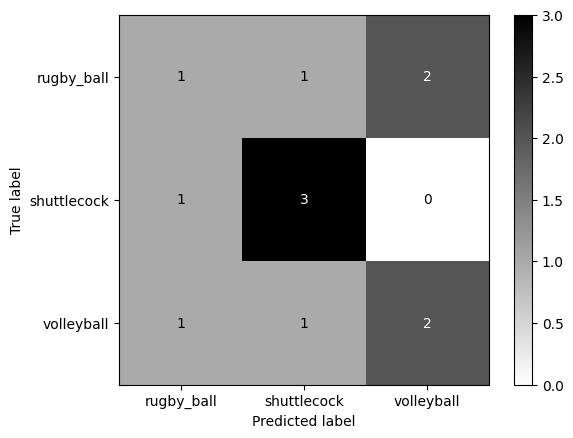

In [49]:

# Calculate and display the confusion matrix
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import argmax
from sklearn.metrics import ConfusionMatrixDisplay

x_validation, y_validation = seperate_labels(validation_generator)
y_pred = model.predict(x_validation, batch_size=BATCH_SIZE)
predictions = np.apply_along_axis(argmax, 1, y_pred)
display_labels = validation_generator.class_indices.keys()

ConfusionMatrixDisplay.from_predictions(y_validation, predictions, display_labels=display_labels, cmap="binary")
plt.show()


In [51]:
# Predicting code for an image
from tensorflow.keras.preprocessing import image
# Please replace the brackets below with the location of your image which need to predict
img_path = '/content/drive/My Drive/SportsBalls/train/cricket_ball/cricket_ball_4.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction)
result = np.argmax(prediction)
print ("res::",result)
label_map = train_generator.class_indices
res = [key for key,val in label_map.items() if val==result]
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.6228864  0.01563167 0.3614819 ]]
res:: 0
['rugby_ball']


In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score

predictions = y_pred[:, 1]
y_true = validation_generator.classes
fpr, tpr, _ = roc_curve(y_true, predictions)
auc = roc_auc_score(y_true, predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1, 1.12))
plt.show()


ValueError: multiclass format is not supported